In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%pip install ultralytics
#%pip install glasses-detector
%pip install pyfacer
%pip install timm
%pip install scikit-learn
%pip install Pillow
%pip install torchvision

from matplotlib import pyplot as plt
#import glasses_detector
import os
import time
from PIL import Image
import matplotlib.image as mpimg
from ultralytics import YOLO
import numpy as np
from sklearn.cluster import KMeans
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation
import torch
from torchvision.transforms.functional import to_pil_image
import facer
import shutil
import csv
import copy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 11.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [4]:
# Directory principale del tuo progetto Waltico
project_dir = '/content/gdrive/My Drive/Progetto Computer Vision/'

In [ ]:
# Directory principale del tuo progetto Giansimone
project_dir = '/content/gdrive/MyDrive/Colab Notebooks/Computer Vision e Deep Learning/Progetto Computer Vision'

### Detection


In [5]:
class FaceDetection:
    def __init__(self, project_dir):
        self._project_dir = project_dir
        self._model_path = os.path.join(self._project_dir, 'data/models/yolov8l-face.pt')
        assert os.path.exists(self._model_path), "Il percorso del modello non è valido"
        self._model = YOLO(self._model_path)
        print("Inizializzazione...")

    def face_detection(self, input_dir='data/images', output_dir='results/faces'):
        # Prepara le directory di input e output
        input_dir = self._prepare_directory(input_dir)
        output_dir = self._prepare_directory(output_dir, create=True)

        # Processa ciascuna immagine nella directory di input
        image_files = os.listdir(input_dir)
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(input_dir, image_file)
            results = self._model(image_path)
            self._process_results(results, image_path, output_dir, i, len(image_files))

        print("Processo concluso con successo")

    def _prepare_directory(self, dir_path, create=False):
        # Costruisce il percorso completo della directory
        full_path = os.path.join(self._project_dir, dir_path)
        if create and not os.path.exists(full_path):
            os.makedirs(full_path)
            print(f"Directory creata: {full_path}")
        return full_path

    def _process_results(self, results, image_path, output_dir, image_index, total_images):
        # Ritaglia e salva le immagini di ciascuna bounding box rilevata
        img = Image.open(image_path)
        for result in results:
            boxes = result.boxes.data
            for box_index, box in enumerate(boxes):
                cropped_img = self._crop_image(img, box)
                output_file = self._generate_output_filename(output_dir, image_index, total_images, box_index, len(boxes))
                cropped_img.save(output_file)

    def _crop_image(self, img, box):
        # Ritaglia l'immagine utilizzando le coordinate della bounding box
        x_min, y_min, x_max, y_max = box.tolist()[:4]
        return img.crop((x_min, y_min, x_max, y_max))

    def _generate_output_filename(self, output_dir, image_index, total_images, box_index, total_boxes):
        # Genera un nome di file per l'immagine ritagliata
        image_index_str = str(image_index).zfill(len(str(total_images)))
        box_index_str = str(box_index).zfill(len(str(total_boxes)))
        return os.path.join(output_dir, f'result_{image_index_str}_{box_index_str}.jpg')


## Face Segmenetation

In [6]:
class FaceSegmentation:
    def __init__(self, project_dir):
        # Imposta directory di progetto e dispositivo
        self._project_dir = project_dir
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Inizializza i rilevatori e parser facciali
        self._face_detector = facer.face_detector('retinaface/mobilenet', device=self._device)
        self._face_parser = facer.face_parser('farl/lapa/448', device=self._device)

    def process_images(self):
        all_segments = {}
        # Processa ciascuna immagine nella directory dei risultati
        for filename in os.listdir(os.path.join(self._project_dir, 'results/faces')):
            image_path = os.path.join(self._project_dir, 'results/faces', filename)
            image = self._load_image(image_path)

            faces = self._detect_faces(image)
            self._visualize_faces(image, faces)

            faces = self._parse_faces(image, faces)
            seg_probs = faces['seg']['logits'].softmax(dim=1)

            all_segments[filename] = self._segment_faces(image, seg_probs, faces)

            self._save_visualization(image, seg_probs, filename)

        return all_segments

    def _load_image(self, image_path):
        # Carica e converte l'immagine nel formato richiesto
        image = facer.hwc2bchw(facer.read_hwc(image_path)).to(device=self._device)
        return image

    def _detect_faces(self, image):
        # Rileva volti nell'immagine
        with torch.inference_mode():
            faces = self._face_detector(image)
        return faces

    def _parse_faces(self, image, faces):
        # Analizza i volti rilevati
        with torch.inference_mode():
            faces = self._face_parser(image, faces)
        return faces

    def _segment_faces(self, image, seg_probs, faces):
        # Segmenta i volti e i relativi componenti
        n_classes = seg_probs.size(1)
        segments = {}
        for face_id in range(seg_probs.size(0)):
            for class_id in range(n_classes):
                mask = (seg_probs[face_id, class_id] > 0.5).float()
                if mask.sum() > 0:
                    if face_id not in segments:
                        segments[face_id] = []
                    segments[face_id].append([mask, faces['seg']['label_names'][class_id]])
        return segments

    def _save_visualization(self, image, seg_probs, filename):
        # Salva la visualizzazione delle segmentazioni
        vis_seg_probs = seg_probs.argmax(dim=1).float() / seg_probs.size(1) * 255
        vis_img = vis_seg_probs.sum(0, keepdim=True)
        vis_img_pil = to_pil_image(vis_img.byte())
        directory = os.path.join(self._project_dir, "results/faces_facer")
        if not os.path.exists(directory):
            os.makedirs(directory)
        vis_img_pil.save(os.path.join(directory, f'result_{filename.split("_")[1]}_{filename.split("_")[2]}'), format='JPEG')

    def _visualize_faces(self, image, faces):
        # Mostra i volti rilevati
        facer.show_bchw(facer.draw_bchw(image, faces))


## Glasses Segmentation

In [ ]:
class GlassesSegmentation:
    def __init__(self, project_dir):
        # Imposta directory di progetto e dispositivo
        self._project_dir = project_dir
        self._glasses_detector = glasses_detector.AnyglassesClassifier()

    def process_images(self):
        all_segments = {}
        # Processa ciascuna immagine nella directory dei risultati
        for filename in os.listdir(os.path.join(self._project_dir, 'data/images')):
            image_path = os.path.join(self._project_dir, 'data/images', filename)
            print(filename)
            image = self._load_image(image_path)
            print(image)

    def _load_image(self, image_path, csv_filename = 'glasses_per_image.csv'):
       # Verifica se la directory per il CSV esiste, altrimenti creala
        csv_dir = os.path.join(self._project_dir, 'results/csv')
        if not os.path.exists(csv_dir):
            os.makedirs(csv_dir)

        csv_path = os.path.join(csv_dir, csv_filename)

        sus = self._glasses_detector (image_path)
        return sus


## Color Extraction

In [7]:
class ColorExtractor:
    def __init__(self, project_dir):
        # Imposta directory di progetto e dispositivo
        self._project_dir = project_dir
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def extract_dominant_colors(self, all_segments, normalize = True):
        dominant_colors = {}
        # Estrae i colori dominanti per ciascun segmento
        for filename, segments in all_segments.items():
            image_tensor = self._load_image(os.path.join(self._project_dir, 'results/faces', filename))
            for face_id, segment_list in segments.items():
                for mask, label_name in segment_list:
                    colors = self._get_segmented_colors(image_tensor, mask)
                    dominant_colors = self._update_dominant_colors(dominant_colors, filename, face_id, label_name, colors)

        return dominant_colors

    def _load_image(self, image_path):
        # Carica e converte l'immagine nel formato richiesto
        image = facer.hwc2bchw(facer.read_hwc(image_path)).to(device=self._device)
        return image

    def _get_segmented_colors(self, image_tensor, mask):
        # Estrae i colori dai segmenti
        pixel_coords = torch.nonzero(mask)
        segmented_colors = [image_tensor[0, :, coord[0], coord[1]].cpu().numpy() for coord in pixel_coords]  # if not self._is_pixel_in_glasses_box(coord, glasses_boxes)]
        return np.array(segmented_colors) if segmented_colors else np.array([])

    def _update_dominant_colors(self, dominant_colors, filename, face_id, label_name, segmented_colors):
        # Aggiorna i colori dominanti per ciascun segmento
        if segmented_colors.size > 0:
            kmeans = KMeans(n_clusters=3).fit(segmented_colors)
            if filename not in dominant_colors:
                dominant_colors[filename] = {}
            if face_id not in dominant_colors[filename]:
                dominant_colors[filename][face_id] = {}
            dominant_colors[filename][face_id][label_name] = kmeans.cluster_centers_

        return dominant_colors

    '''def _is_pixel_in_glasses_box(self, coord, glasses_boxes):
        # Verifica se un pixel è dentro una bounding box degli occhiali
        return any(x_min <= coord[1] <= x_max and y_min <= coord[0] <= y_max for x_min, y_min, x_max, y_max in glasses_boxes)'''

    def save_dominant_colors_to_csv(self, dominant_colors, csv_filename='dominant_colors.csv'):
      # Verifica se la directory per il CSV esiste, altrimenti creala
      csv_dir = os.path.join(self._project_dir, 'results/csv')
      if not os.path.exists(csv_dir):
          os.makedirs(csv_dir)

      csv_path = os.path.join(csv_dir, csv_filename)

      # Lista delle etichette (deve corrispondere alle etichette nei dati)
      labels = [
          'background', 'face', 'rb', 'lb', 're', 'le', 'nose', 'ulip', 'imouth', 'llip', 'hair'
      ]

      # Prepara l'intestazione del CSV
      columns = ['Filename', 'Face ID']
      for label in labels:
          columns.extend([f'Color1-{label}', f'Color2-{label}', f'Color3-{label}'])

      # Salva i colori dominanti in un file CSV
      with open(csv_path, mode='w', newline='') as csv_file:
          writer = csv.writer(csv_file)
          writer.writerow(columns)

          for filename, face_data in dominant_colors.items():
              for face_id, labels_data in face_data.items():
                  row = [filename, face_id]
                  for label in labels:
                      colors = labels_data.get(label, [np.nan, np.nan, np.nan])
                      row.extend(colors)
                  writer.writerow(row)

    def _are_colors_normalized(self, dominant_colors):
      # Controlla che tutti i valori siano normalizzati
      return all(
          (0 <= colors).all() and (colors <= 1).all()
          for faces in dominant_colors.values()
          for segments in faces.values()
          for colors in segments.values()
      )

    def _normalize_colors(self, dominant_colors):
      # Normalizza i valori RGB nel range [0, 1]
      for filename, faces in dominant_colors.items():
          for face_id, segments in faces.items():
              for label_name, colors in segments.items():
                  dominant_colors[filename][face_id][label_name] = colors / 255.0

    def show_colors(self, dominant_colors):
        # Creare una copia di dominant_colors per evitare modifiche all'originale
        dominant_colors_copy = copy.deepcopy(dominant_colors)

        # Normalizza i valori RGB nel range [0, 1] se non sono stati già normalizzati
        if not self._are_colors_normalized(dominant_colors_copy):
            self._normalize_colors(dominant_colors_copy)

        # Visualizza i colori normalizzati
        for filename, faces in dominant_colors_copy.items():
            for face_id, segments in faces.items():
                for label_name, colors in segments.items():
                    print(f"\nFilename: {filename}, Face ID: {face_id}, Label: {label_name}")
                    fig, ax = plt.subplots()
                    ax.imshow([colors], aspect='auto')
                    ax.axis('off')
                    plt.show()

    def match_season(self, dominant_colors, seasons_centroids):
      season_matches = {}
      for filename, faces in dominant_colors.items():
          season_matches[filename] = {}
          for face_id, segments in faces.items():
              best_season = None
              min_distance = float('inf')
              for season, centroids in seasons_centroids.items():
                  for color in segments.values():
                      _, distance = pairwise_distances_argmin_min(color.reshape(1, -1), centroids)
                      if distance[0] < min_distance:
                          min_distance = distance[0]
                          best_season = season
              season_matches[filename][face_id] = best_season
      return season_matches



## ColorClusterer

In [33]:
class ColorClusterer:
  def __init__(self, project_dir):
    # Imposta directory di progetto e dispositivo
    self._project_dir = project_dir
    self._device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Definizione delle etichette di armonia cromatica per i colori
    self.color_labels = np.concatenate([
    np.array(["Autunno Chiaro"] * 20),
    np.array(["Autunno Profondo"] * 20),
    np.array(["Autunno Cald0"] * 20),
    np.array(["Inverno Chiaro"] * 20),
    np.array(["Primavera Chiaro"] * 20),
    np.array(["Primavera Intenso"] * 20),
    np.array(["Primavera Profonda"] * 20),
    np.array(["Estate Chiara"] * 20),
    np.array(["Estate Fredda"] * 20),
    np.array(["Estate Profonda"] * 20),
    np.array(["Inverno Fredda"] * 20),
    np.array(["Inverno Profonda"] * 20)
    ])

    # Definizione dei colori in formato RGB
    self.colors = np.concatenate([
    # Autunno Chiaro
    np.array([
        [255, 165, 0], [255, 127, 80], [255, 218, 185], [224, 149, 128], [255, 255, 0],
        [255, 191, 0], [255, 215, 0], [128, 128, 0], [210, 180, 140], [255, 219, 88],
        [255, 191, 0], [205, 127, 50], [255, 179, 71], [255, 165, 0], [207, 181, 59],
        [218, 165, 32], [102, 93, 30], [255, 186, 124], [204, 85, 0], [204, 119, 34]
    ]),
    # Autunno Profondo
    np.array([
        [139, 69, 19], [128, 0, 32], [183, 65, 14], [205, 127, 50], [183, 65, 14],
        [101, 67, 33], [255, 191, 0], [242, 169, 104], [207, 181, 59], [178, 34, 34],
        [91, 58, 39], [139, 69, 19], [191, 87, 0], [102, 93, 30], [153, 101, 21],
        [224, 149, 128], [218, 165, 32], [128, 0, 0], [204, 85, 0], [255, 215, 0]
    ]),
    #Autunno Caldo
    np.array([
        [183, 65, 14], [255, 219, 88], [233, 116, 81], [91, 58, 39], [255, 117, 24],
        [255, 191, 0], [204, 78, 92], [205, 127, 50], [128, 128, 0], [178, 34, 34],
        [255, 140, 0], [207, 181, 59], [218, 165, 32], [178, 34, 34], [139, 69, 19],
        [102, 93, 30], [191, 87, 0], [204, 85, 0], [101, 67, 33], [255, 215, 0]
    ]),
    # Inverno Chiaro
    np.array([
        [255, 255, 255], [175, 238, 238], [211, 211, 211], [135, 206, 250], [152, 251, 152],
        [178, 255, 255], [0, 127, 255], [240, 255, 255], [176, 224, 230], [255, 228, 225],
        [255, 253, 208], [245, 245, 220], [255, 255, 128], [230, 230, 250], [255, 218, 185],
        [255, 250, 205], [152, 251, 152], [192, 192, 192], [204, 255, 255], [229, 204, 255]
    ]),
    # Primavera Chiaro
    np.array([
        [255, 255, 102], [0, 201, 87], [255, 165, 0], [255, 192, 203], [173, 216, 230],
        [230, 230, 250], [255, 218, 185], [253, 233, 16], [64, 224, 208], [253, 188, 180],
        [191, 255, 0], [230, 230, 250], [252, 236, 3], [152, 251, 152], [255, 0, 0],
        [0, 127, 255], [0, 255, 255], [221, 160, 221], [255, 255, 128], [144, 238, 144]
    ]),
    # Primavera Intenso
    np.array([
        [255, 102, 102], [0, 206, 209], [178, 102, 255], [102, 255, 102], [255, 69, 0],
        [255, 69, 0], [0, 0, 255], [255, 20, 147], [255, 255, 0], [57, 255, 20],
        [153, 50, 204], [222, 49, 99], [255, 140, 0], [65, 105, 225], [0, 255, 0],
        [255, 255, 0], [255, 0, 255], [255, 0, 255], [255, 0, 0], [255, 20, 147]
    ]),
    # Primavera Profonda
    np.array([
        [205, 127, 50], [0, 53, 106], [128, 0, 128], [0, 71, 171], [0, 100, 0],
        [139, 69, 19], [207, 181, 59], [128, 70, 27], [156, 17, 17], [138, 43, 226],
        [34, 139, 34], [0, 0, 0], [25, 25, 112],[75, 83, 32], [178, 34, 34],
        [65, 105, 225], [102, 93, 30], [83, 3, 48], [207, 181, 59], [0, 0, 128]
    ]),
    # Estate Chiara
    np.array([
        [255, 255, 102], [255, 140, 105], [255, 160, 122], [255, 182, 193], [255, 218, 185],
        [238, 232, 170], [255, 250, 205], [240, 255, 240], [245, 245, 220], [255, 228, 196],
        [255, 240, 245], [250, 240, 230], [255, 228, 225], [255, 222, 173], [245, 255, 250],
        [253, 245, 230], [255, 218, 185], [255, 222, 173], [255, 245, 238], [253, 245, 230]
    ]),
    # Estate Fredda
    np.array([
        [135, 206, 250], [176, 224, 230], [70, 130, 180], [135, 206, 235], [0, 191, 255],
        [100, 149, 237], [0, 0, 255], [30, 144, 255], [176, 196, 222], [173, 216, 230],
        [0, 206, 209], [0, 255, 255], [173, 216, 230], [25, 25, 112], [70, 130, 180],
        [0, 191, 255], [65, 105, 225], [0, 191, 255], [0, 206, 209], [65, 105, 225]
    ]),
    # Estate profonda
    np.array([
        [123, 17, 19], [34, 139, 34], [25, 25, 112], [128, 0, 0], [0, 51, 102],
        [75, 83, 32], [139, 69, 19], [0, 0, 0], [138, 43, 226], [0, 106, 78],
        [65, 105, 225], [128, 0, 128], [0, 53, 106], [139, 0, 0], [0, 102, 0],
        [128, 0, 32], [92, 64, 51], [65, 105, 225], [173, 167, 110], [51, 51, 51]
    ]),
    # Inverno Fredda
    np.array([
        [0, 0, 0], [255, 255, 255], [128, 128, 128], [0, 0, 128], [65, 105, 225],
        [25, 25, 112], [0, 0, 128], [0, 53, 106], [0, 51, 102], [0, 71, 171],
        [0, 0, 139], [18, 14, 10], [51, 51, 51], [65, 66, 87], [70, 130, 180],
        [119, 136, 153], [54, 69, 79], [18, 14, 10], [0, 12, 51], [25, 25, 112]
    ]),
    # Inverno Profonda
    np.array([
        [0, 0, 0], [25, 25, 112], [138, 43, 226], [34, 139, 34], [0, 0, 139],
        [51, 51, 51], [0, 53, 106], [70, 130, 180], [0, 51, 102], [18, 14, 10],
        [0, 12, 51], [0, 0, 128], [18, 14, 10], [119, 136, 153], [65, 105, 225],
        [65, 66, 87], [25, 25, 112], [0, 12, 51], [0, 71, 171], [54, 69, 79]
    ])
    ])

  # Funzione per visualizzare i colori
  def plot_colors(self, colors, labels, title):
      plt.figure(figsize=(8, 6))
      plt.scatter(colors[:, 0], colors[:, 1], c=colors / 255.0, label=labels)
      plt.title(title)
      plt.xlabel('Red')
      plt.ylabel('Green')
      plt.legend()
      plt.grid(True)
      plt.show()

  def label_propagation(self,colors):
    # Inizializza un array vuoto per i colori
    colori = []

    # Itera attraverso i risultati nel dizionario
    for risultato in colors.values():
        # Itera attraverso le chiavi di ogni risultato
        for chiave, valore in risultato.items():
            # Se il valore è un dizionario
            if isinstance(valore, dict):
                # Itera attraverso le chiavi di questo dizionario
                for parte, colori_parte in valore.items():
                    # Aggiungi il colore all'array
                    for colore in colori_parte:
                        colori.append(colore)

    # Converti colori in un array NumPy
    colori = np.array(colori)

    # Creare un'istanza di LabelPropagation e adattarla ai dati etichettati
    label_prop_model = LabelPropagation()
    label_prop_model.fit(self.colors, self.color_labels)

    # Prevedere le etichette per i colori non etichettati
    predicted_labels_unlabeled = label_prop_model.predict(colori)

    '''for colore, etichetta_predetta in zip(colori, predicted_labels_unlabeled):
          print(f"Colore: {colore}, Etichetta predetta: {etichetta_predetta}")'''

    self.visualizza_colori_con_etichette(colori,predicted_labels_unlabeled)

  def visualizza_colori_con_etichette(self, colori, etichette_predette):
    for i, colore in enumerate(colori):
        color = [colore[0] / 255, colore[1] / 255, colore[2] / 255]
        etichetta_predetta = etichette_predette[i]
        print(f"\nLabel: {etichetta_predetta} color: {color}")
        plt.figure(figsize=(1, 1))
        plt.imshow([[color]])
        plt.axis('off')  # Disabilita gli assi
        plt.show()





  def cluster(self, colors):
    # Inizializza un array vuoto per i colori
    colori = []

    # Itera attraverso i risultati nel dizionario
    for risultato in colors.values():
        # Itera attraverso le chiavi di ogni risultato
        for chiave, valore in risultato.items():
            # Se il valore è un dizionario
            if isinstance(valore, dict):
                # Itera attraverso le chiavi di questo dizionario
                for parte, colori_parte in valore.items():
                    # Aggiungi il colore all'array
                    for colore in colori_parte:
                        colori.append(colore)

    # Converti colori in un array NumPy
    colori = np.array(colori)

    kmeans = KMeans(n_clusters=12).fit(colori)
    # Visualizzazione dei cluster in tre dimensioni
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(colori[:, 0], colori[:, 1], colori[:, 2], c=kmeans.labels_, cmap='viridis')
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], marker='x', color='red')
    ax.set_xlabel('Red')
    ax.set_ylabel('Blue')
    ax.set_zlabel('Green')
    plt.title('Visualizzazione dei cluster in tre dimensioni')
    plt.show()

    # Colori dei centroidi
    centroid_colors = kmeans.cluster_centers_ / 255.0  # Normalizza i colori tra 0 e 1

    # Visualizza i colori dei centroidi
    fig, ax = plt.subplots(1, 12, figsize=(15, 2))
    for i in range(12):
        ax[i].imshow([[centroid_colors[i]]])
        ax[i].axis('off')
    plt.show()

    # Visualizza i colori per ogni cluster
    clusters = {i: [] for i in range(12)}
    for label, color in zip(kmeans.labels_, colori):
        clusters[label].append(color)
    tot_colors=0
    fig, axes = plt.subplots(12, 1, figsize=(15, 12))
    for cluster_id, cluster_colors in clusters.items():
        tot_colors += len(cluster_colors)
        cluster_colors = np.array(cluster_colors) / 255.0  # Normalizza i colori tra 0 e 1
        axes[cluster_id].imshow([cluster_colors])
        axes[cluster_id].axis('off')
        axes[cluster_id].set_title(f'Cluster {cluster_id}')
    plt.tight_layout()
    plt.show()
    print(tot_colors)

## Main

In [9]:
fd = FaceDetection(project_dir)
fd.face_detection()

WARNING ⚠️ /content/gdrive/My Drive/Progetto Computer Vision/data/models/yolov8l-face.pt appears to require 'dill', which is not in ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 9.3s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Inizializzazione...

image 1/1 /content/gdrive/My Drive/Progetto Computer Vision/data/images/WALTER fototessera crop.jpg: 960x672 1 face, 124.9ms
Speed: 18.0ms preprocess, 124.9ms inference, 845.1ms postprocess per image at shape (1, 3, 960, 672)

image 1/1 /content/gdrive/M

In [10]:
# Inizializza e processa le immagini per la segmentazione facciale
face_segmentation = FaceSegmentation(project_dir)

Downloading: "https://github.com/elliottzheng/face-detection/releases/download/0.0.1/mobilenet0.25_Final.pth" to /root/.cache/torch/hub/checkpoints/mobilenet0.25_Final.pth
100%|██████████| 1.71M/1.71M [00:00<00:00, 23.5MB/s]
Downloading: "https://github.com/FacePerceiver/facer/releases/download/models-v1/face_parsing.farl.lapa.main_ema_136500_jit191.pt" to /root/.cache/torch/hub/checkpoints/face_parsing.farl.lapa.main_ema_136500_jit191.pt
100%|██████████| 617M/617M [00:06<00:00, 98.4MB/s]


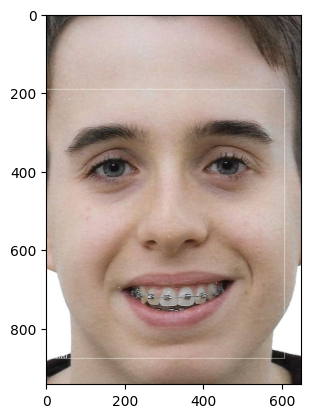

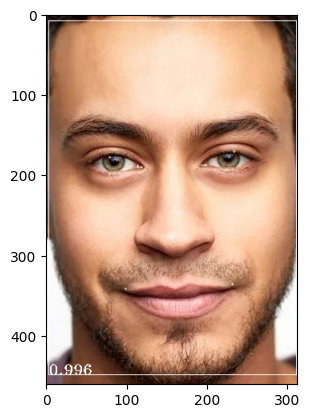

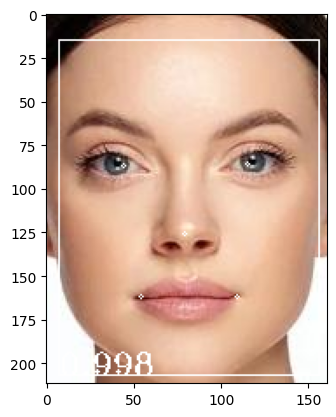

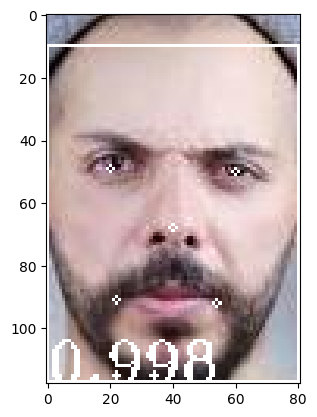

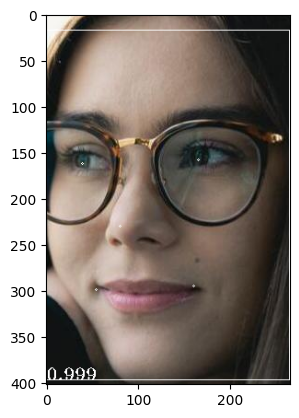

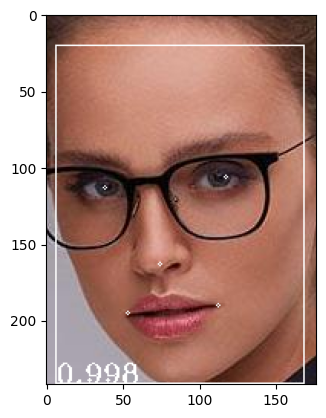

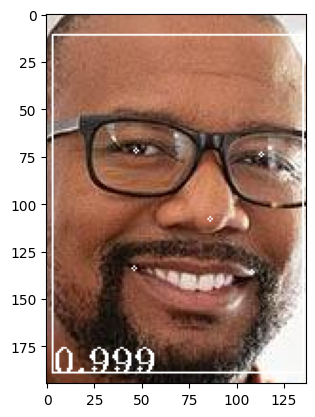

In [11]:
segments = face_segmentation.process_images()

In [ ]:
'''gs = GlassesSegmentation(project_dir)'''

'gs = GlassesSegmentation(project_dir)'

In [ ]:
'''gs.process_images()'''

'gs.process_images()'

In [29]:
# Inizializza e estrai i colori dominanti dai segmenti facciali
color_extractor = ColorExtractor(project_dir)

In [30]:
dominant_colors = color_extractor.extract_dominant_colors(segments)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8


Filename: result_0_0.jpg, Face ID: 0, Label: background


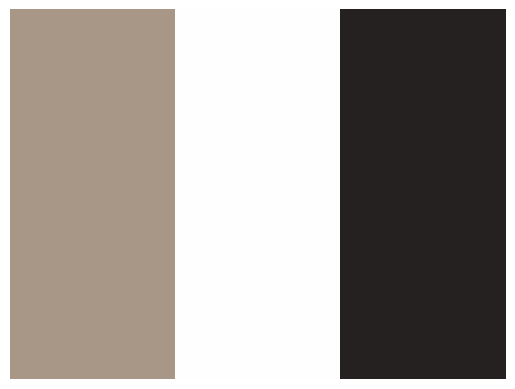


Filename: result_0_0.jpg, Face ID: 0, Label: face


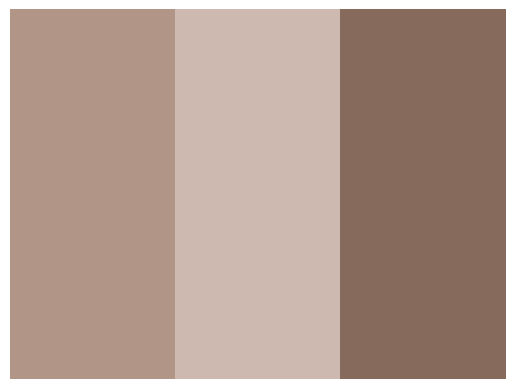


Filename: result_0_0.jpg, Face ID: 0, Label: rb


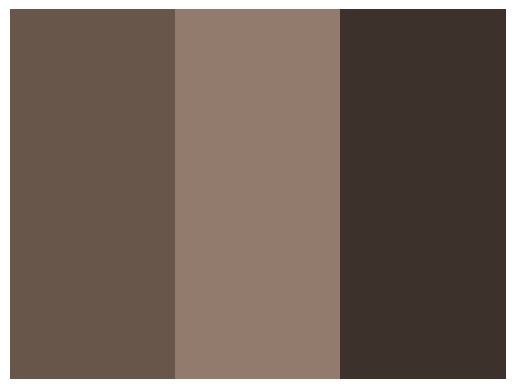


Filename: result_0_0.jpg, Face ID: 0, Label: lb


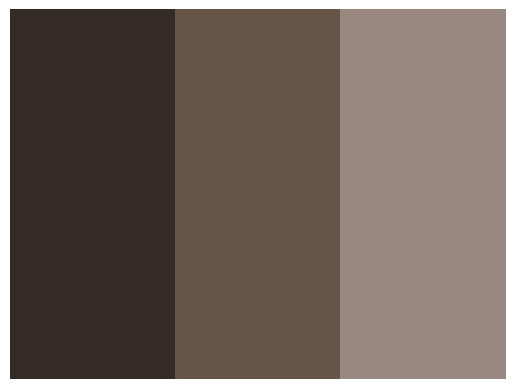


Filename: result_0_0.jpg, Face ID: 0, Label: re


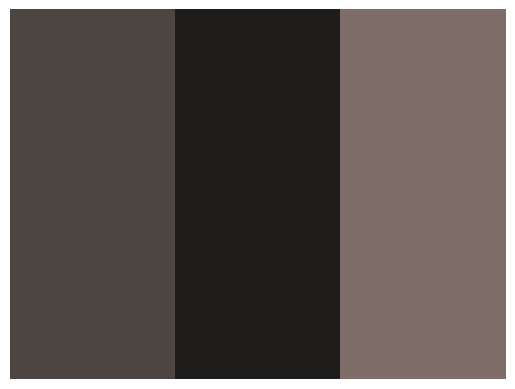


Filename: result_0_0.jpg, Face ID: 0, Label: le


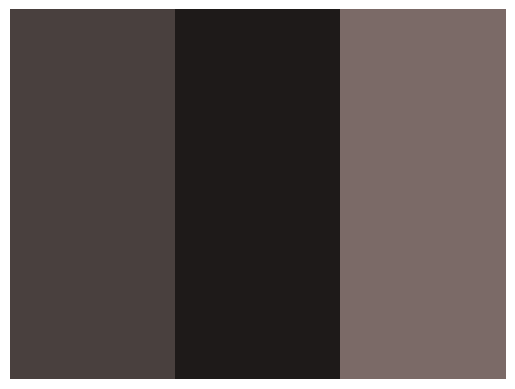


Filename: result_0_0.jpg, Face ID: 0, Label: nose


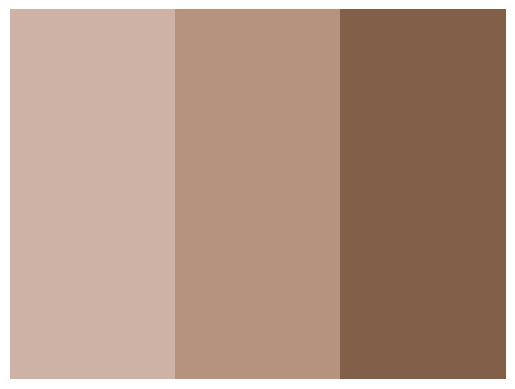


Filename: result_0_0.jpg, Face ID: 0, Label: ulip


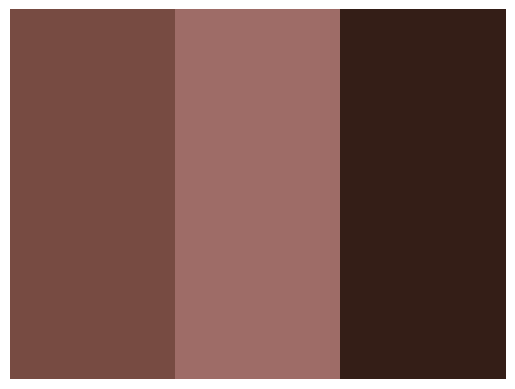


Filename: result_0_0.jpg, Face ID: 0, Label: imouth


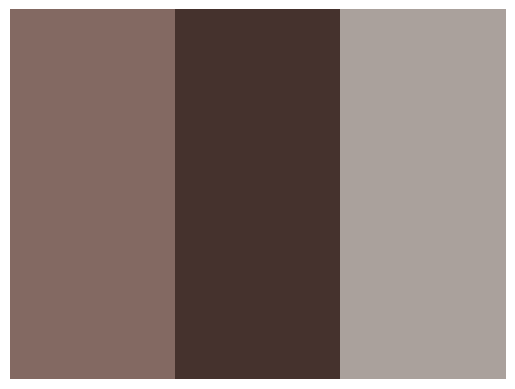


Filename: result_0_0.jpg, Face ID: 0, Label: llip


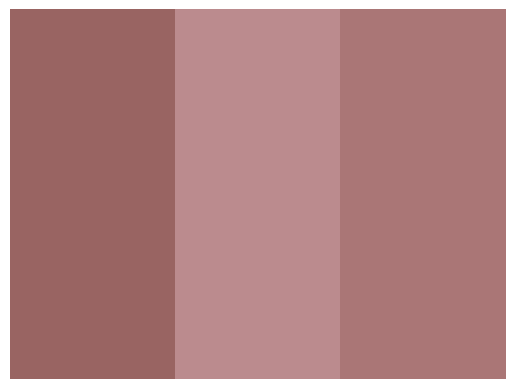


Filename: result_0_0.jpg, Face ID: 0, Label: hair


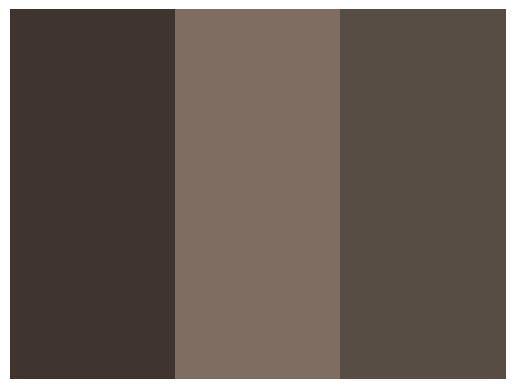


Filename: result_1_0.jpg, Face ID: 0, Label: background


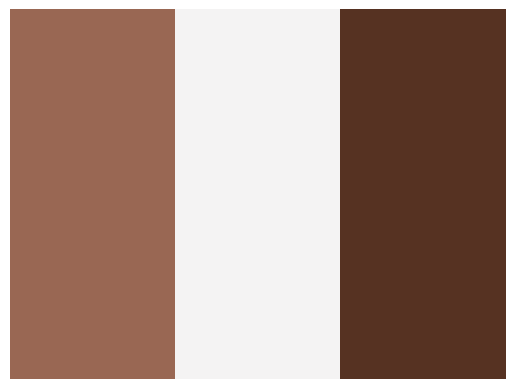


Filename: result_1_0.jpg, Face ID: 0, Label: face


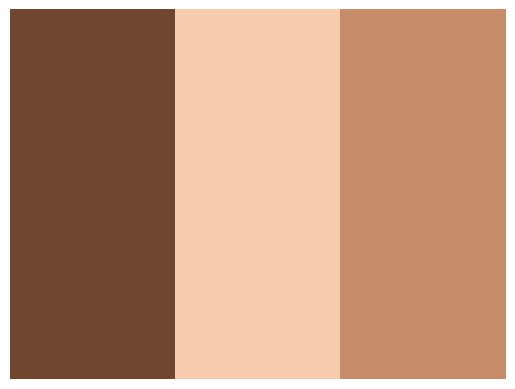


Filename: result_1_0.jpg, Face ID: 0, Label: rb


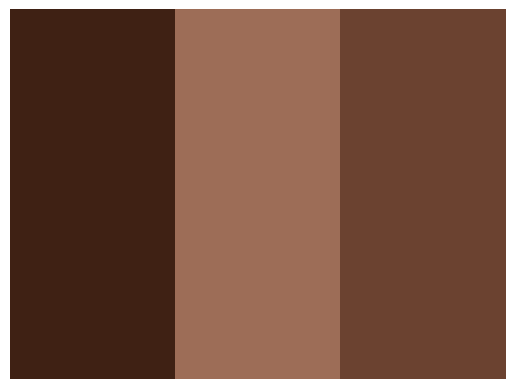


Filename: result_1_0.jpg, Face ID: 0, Label: lb


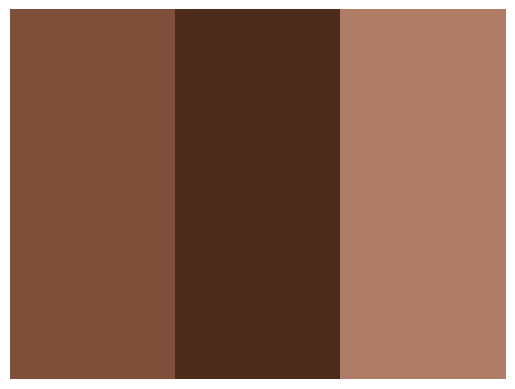


Filename: result_1_0.jpg, Face ID: 0, Label: re


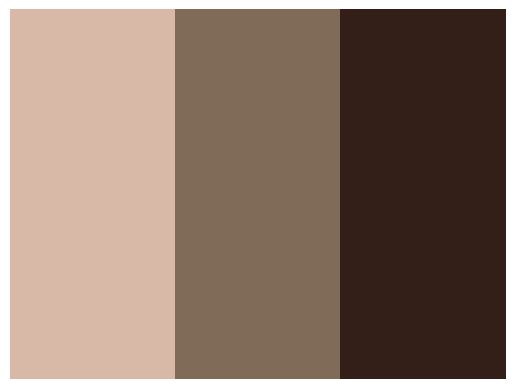


Filename: result_1_0.jpg, Face ID: 0, Label: le


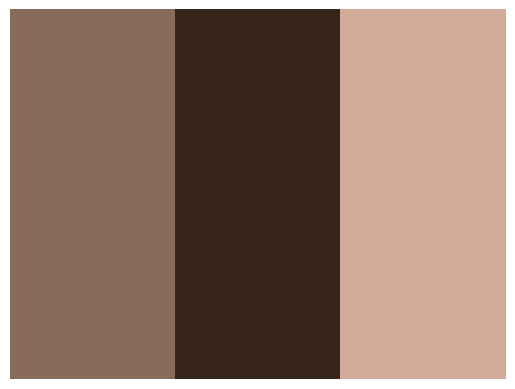


Filename: result_1_0.jpg, Face ID: 0, Label: nose


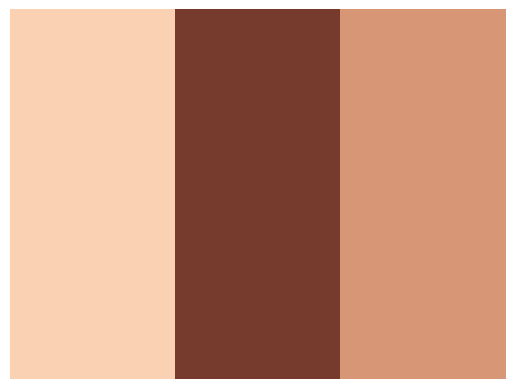


Filename: result_1_0.jpg, Face ID: 0, Label: ulip


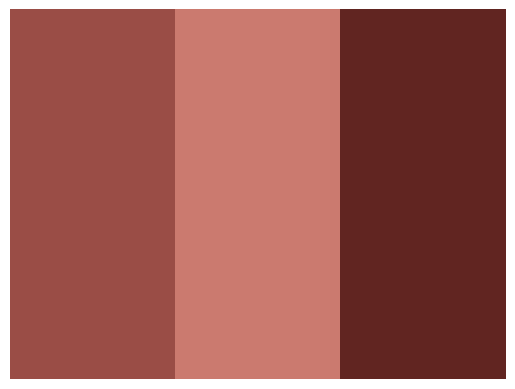


Filename: result_1_0.jpg, Face ID: 0, Label: imouth


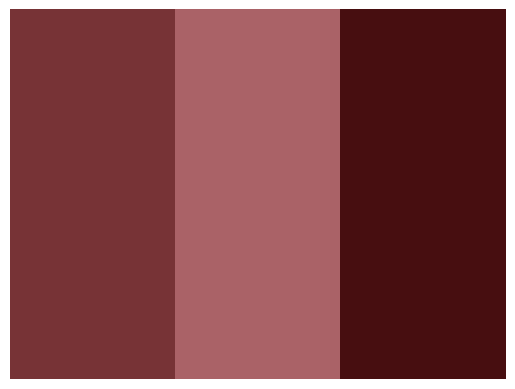


Filename: result_1_0.jpg, Face ID: 0, Label: llip


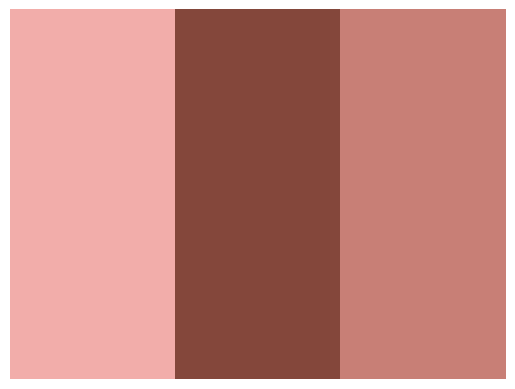


Filename: result_1_0.jpg, Face ID: 0, Label: hair


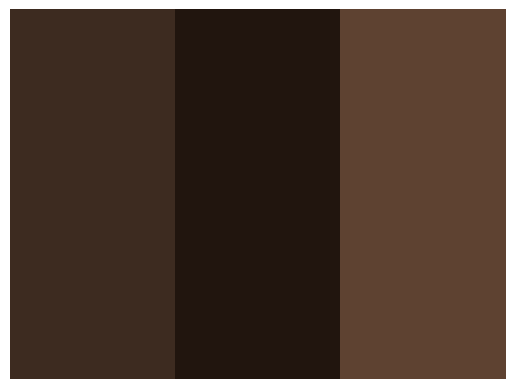


Filename: result_2_0.jpg, Face ID: 0, Label: background


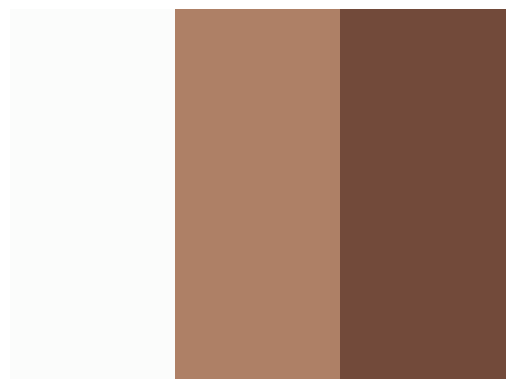


Filename: result_2_0.jpg, Face ID: 0, Label: face


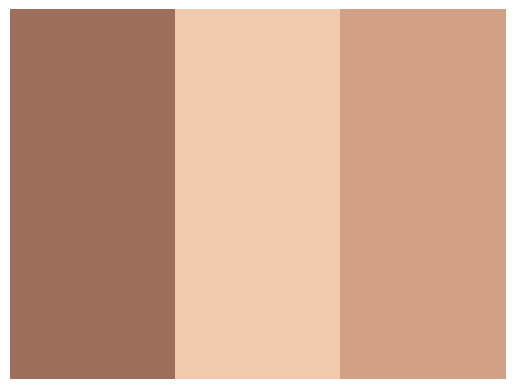


Filename: result_2_0.jpg, Face ID: 0, Label: rb


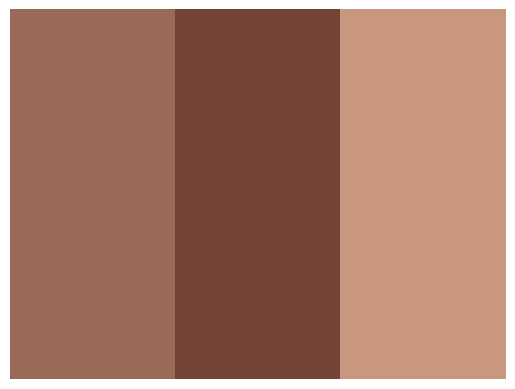


Filename: result_2_0.jpg, Face ID: 0, Label: lb


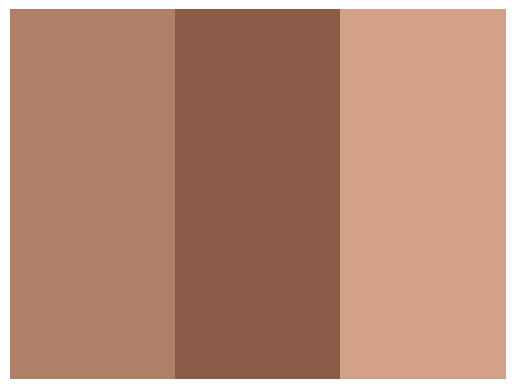


Filename: result_2_0.jpg, Face ID: 0, Label: re


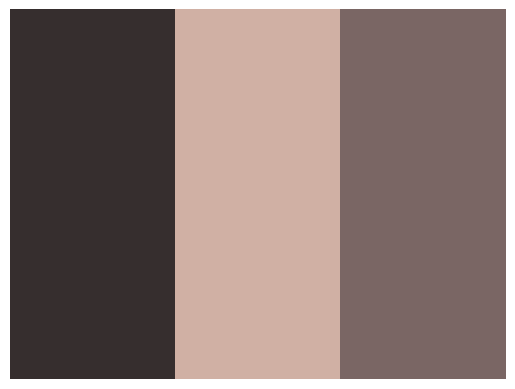


Filename: result_2_0.jpg, Face ID: 0, Label: le


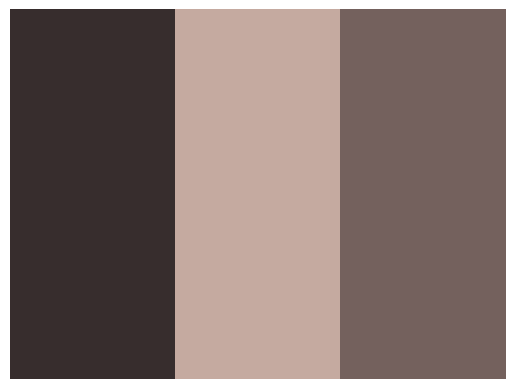


Filename: result_2_0.jpg, Face ID: 0, Label: nose


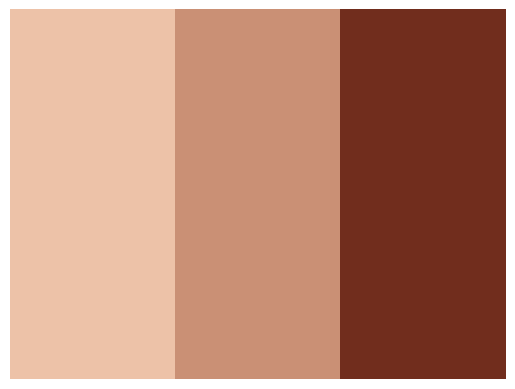


Filename: result_2_0.jpg, Face ID: 0, Label: ulip


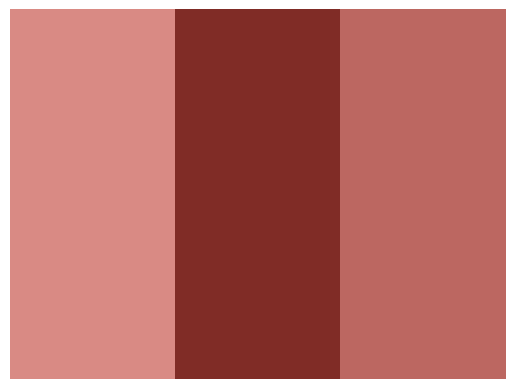


Filename: result_2_0.jpg, Face ID: 0, Label: imouth


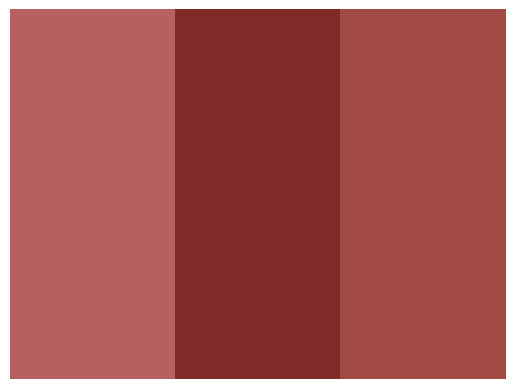


Filename: result_2_0.jpg, Face ID: 0, Label: llip


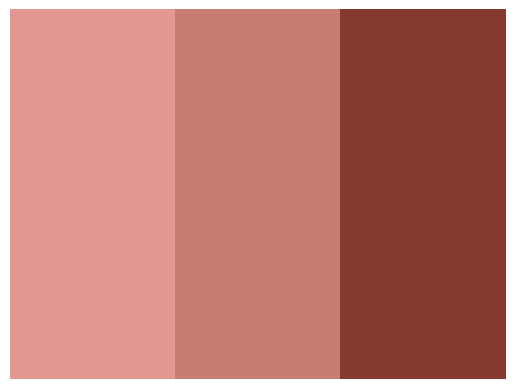


Filename: result_2_0.jpg, Face ID: 0, Label: hair


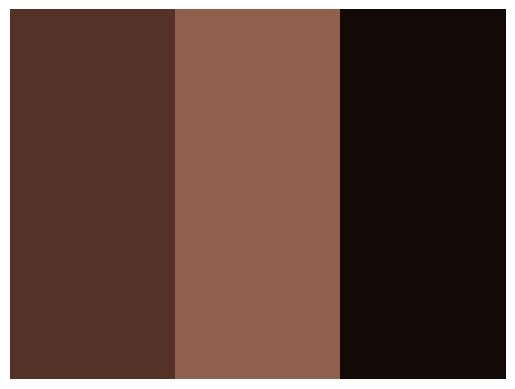


Filename: result_3_0.jpg, Face ID: 0, Label: background


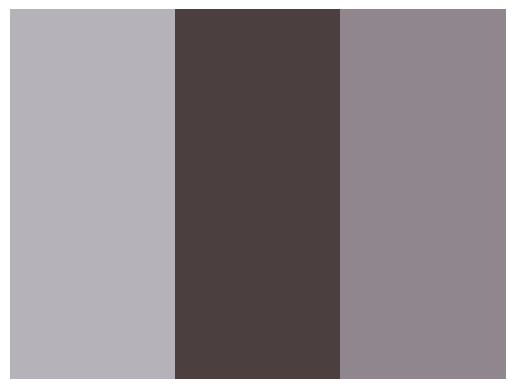


Filename: result_3_0.jpg, Face ID: 0, Label: face


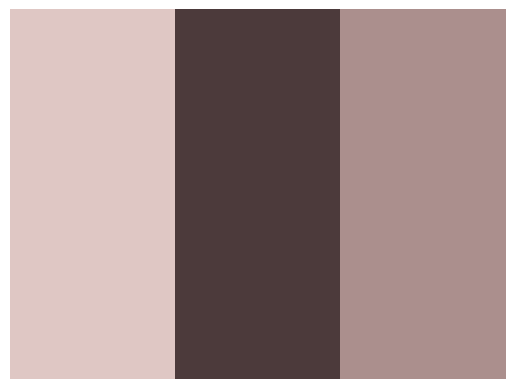


Filename: result_3_0.jpg, Face ID: 0, Label: rb


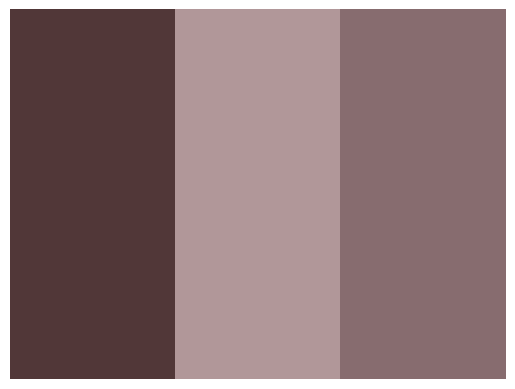


Filename: result_3_0.jpg, Face ID: 0, Label: lb


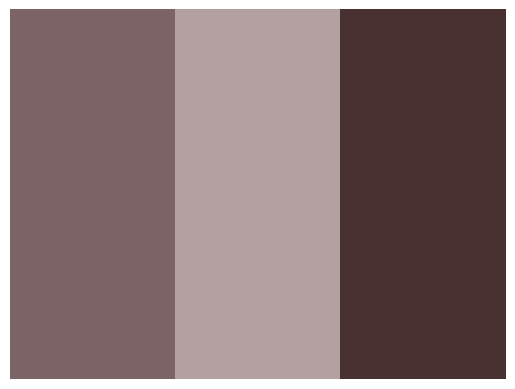


Filename: result_3_0.jpg, Face ID: 0, Label: re


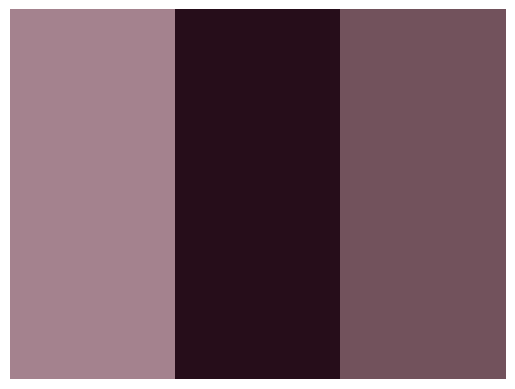


Filename: result_3_0.jpg, Face ID: 0, Label: le


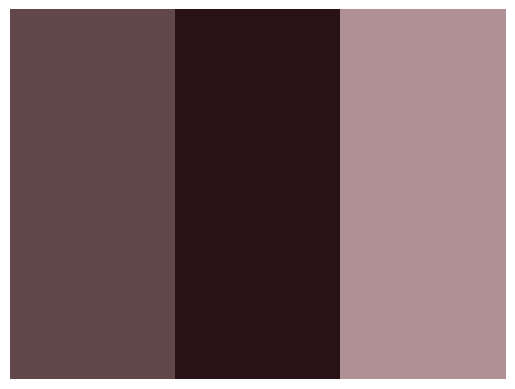


Filename: result_3_0.jpg, Face ID: 0, Label: nose


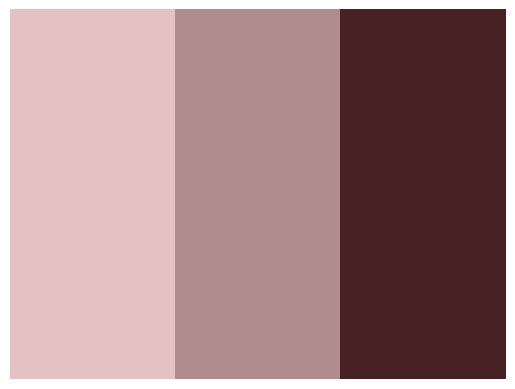


Filename: result_3_0.jpg, Face ID: 0, Label: ulip


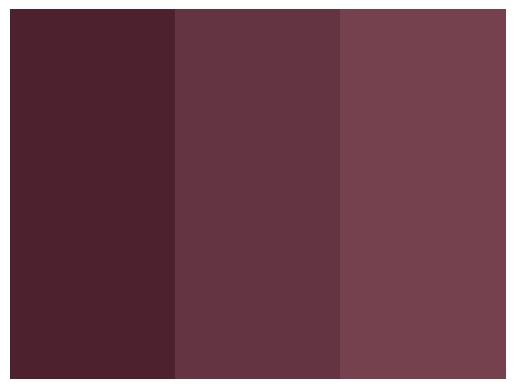


Filename: result_3_0.jpg, Face ID: 0, Label: llip


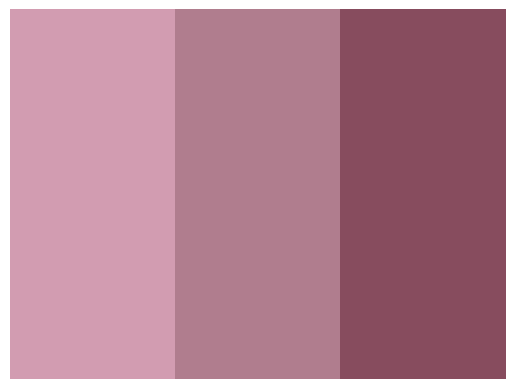


Filename: result_3_0.jpg, Face ID: 0, Label: hair


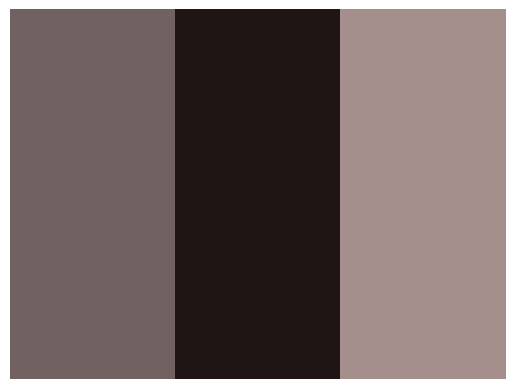


Filename: result_4_0.jpg, Face ID: 0, Label: background


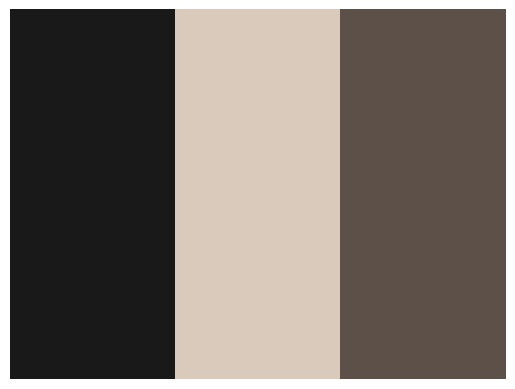


Filename: result_4_0.jpg, Face ID: 0, Label: face


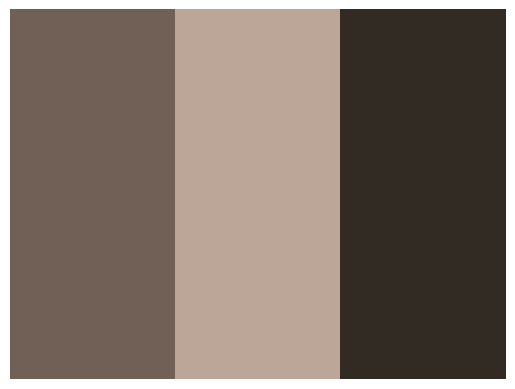


Filename: result_4_0.jpg, Face ID: 0, Label: rb


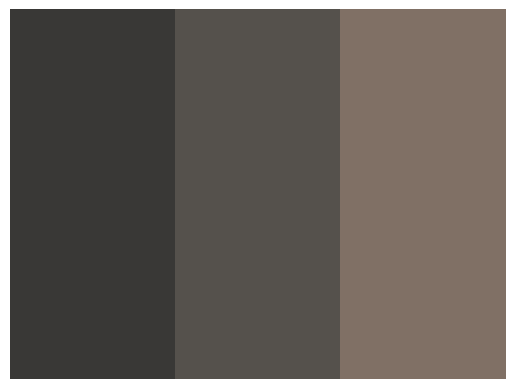


Filename: result_4_0.jpg, Face ID: 0, Label: lb


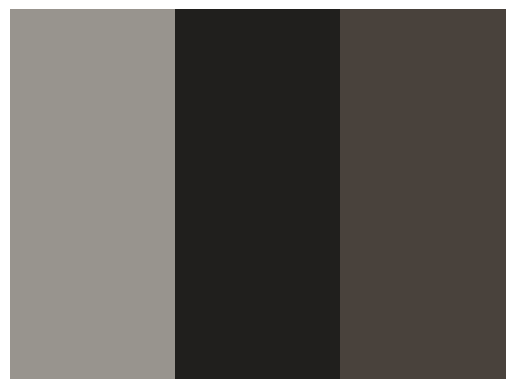


Filename: result_4_0.jpg, Face ID: 0, Label: re


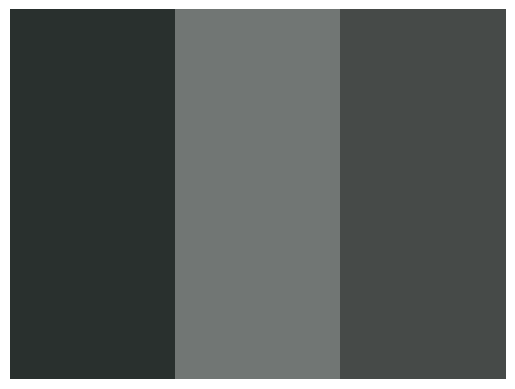


Filename: result_4_0.jpg, Face ID: 0, Label: le


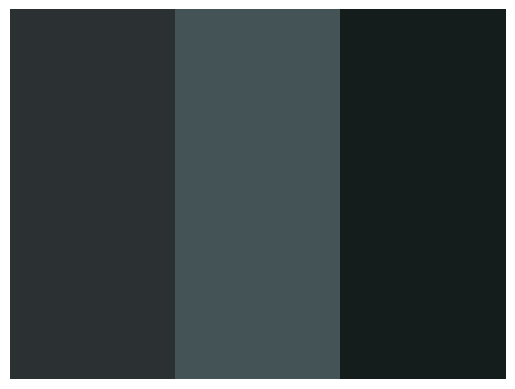


Filename: result_4_0.jpg, Face ID: 0, Label: nose


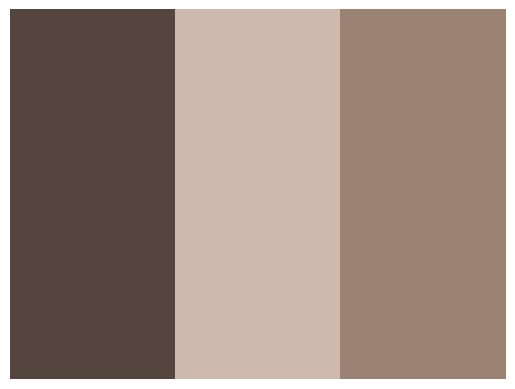


Filename: result_4_0.jpg, Face ID: 0, Label: ulip


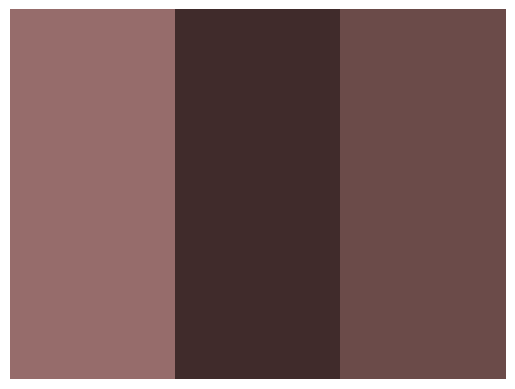


Filename: result_4_0.jpg, Face ID: 0, Label: llip


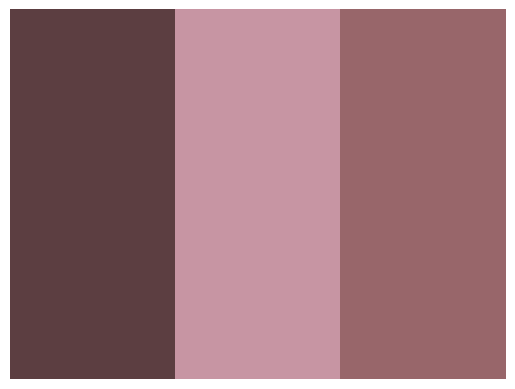


Filename: result_4_0.jpg, Face ID: 0, Label: hair


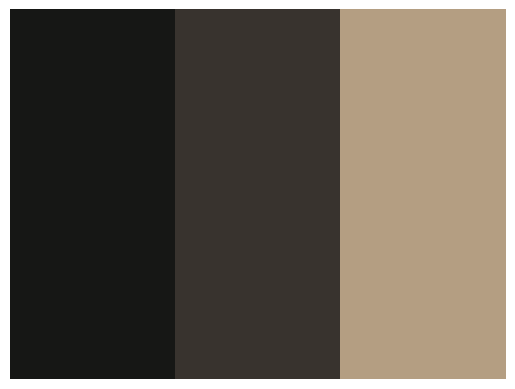


Filename: result_5_0.jpg, Face ID: 0, Label: background


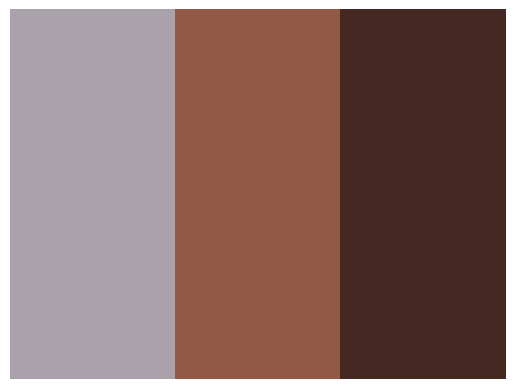


Filename: result_5_0.jpg, Face ID: 0, Label: face


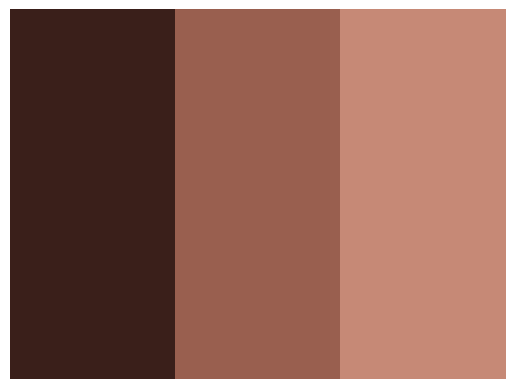


Filename: result_5_0.jpg, Face ID: 0, Label: rb


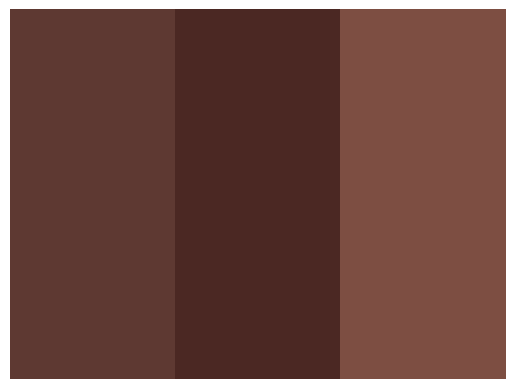


Filename: result_5_0.jpg, Face ID: 0, Label: lb


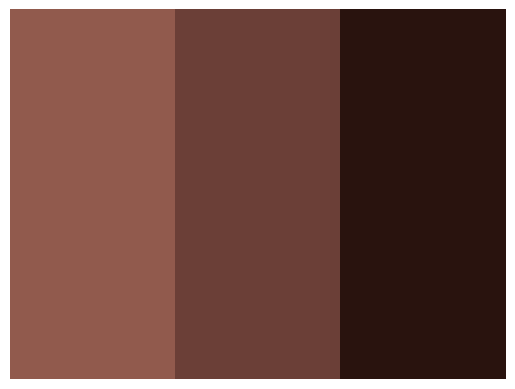


Filename: result_5_0.jpg, Face ID: 0, Label: re


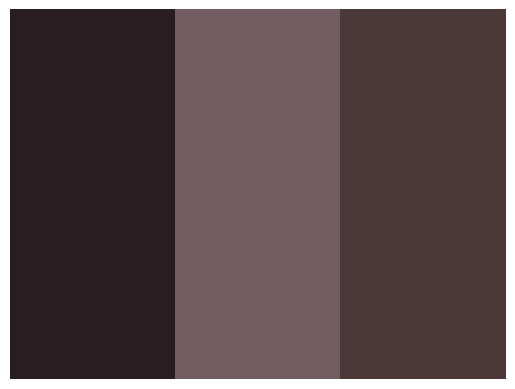


Filename: result_5_0.jpg, Face ID: 0, Label: le


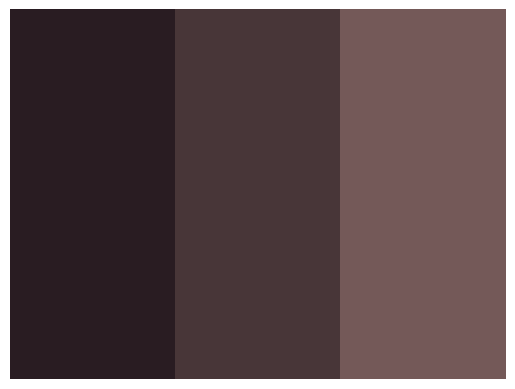


Filename: result_5_0.jpg, Face ID: 0, Label: nose


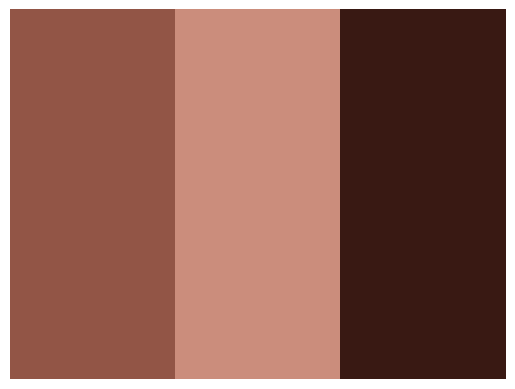


Filename: result_5_0.jpg, Face ID: 0, Label: ulip


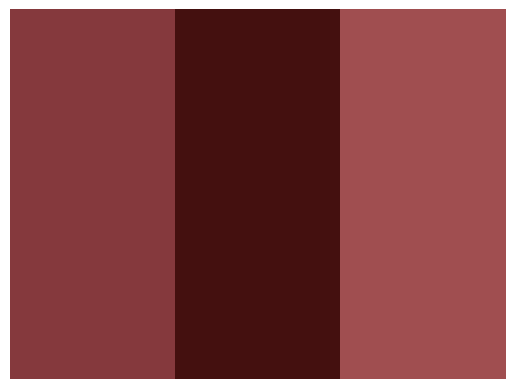


Filename: result_5_0.jpg, Face ID: 0, Label: imouth


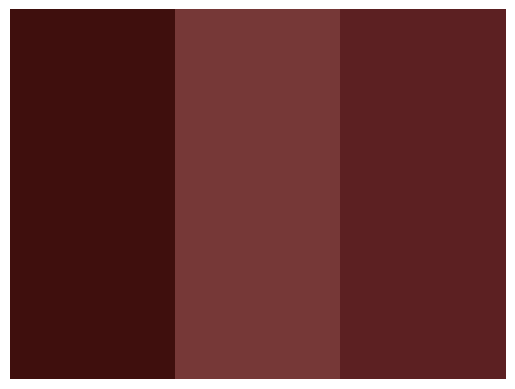


Filename: result_5_0.jpg, Face ID: 0, Label: llip


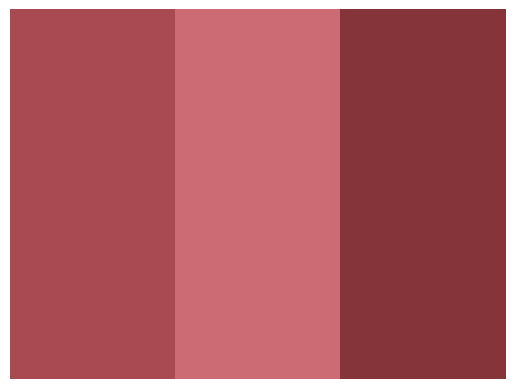


Filename: result_5_0.jpg, Face ID: 0, Label: hair


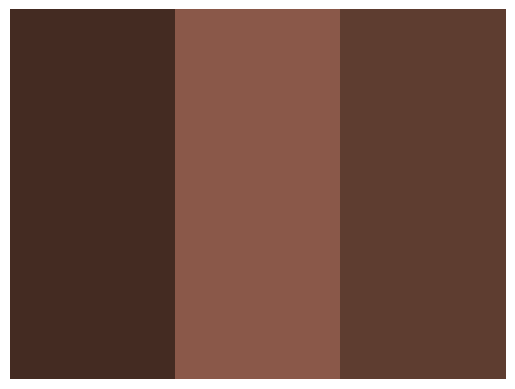


Filename: result_6_0.jpg, Face ID: 0, Label: background


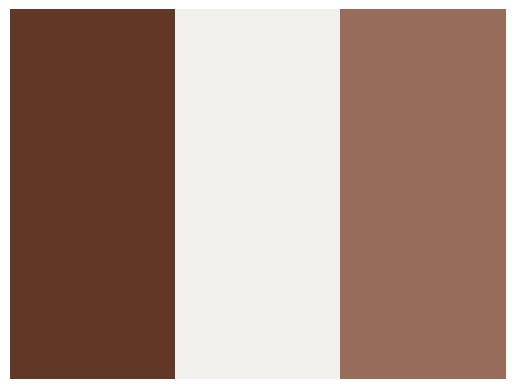


Filename: result_6_0.jpg, Face ID: 0, Label: face


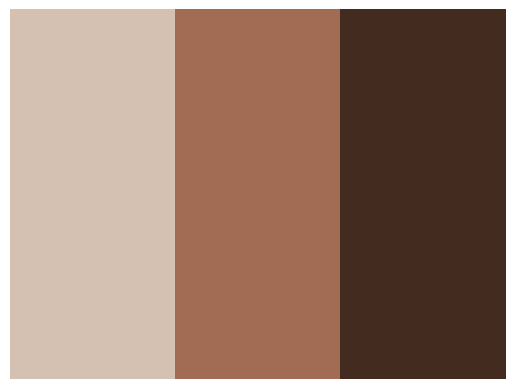


Filename: result_6_0.jpg, Face ID: 0, Label: rb


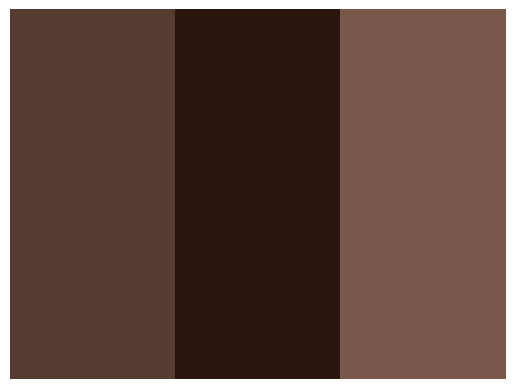


Filename: result_6_0.jpg, Face ID: 0, Label: lb


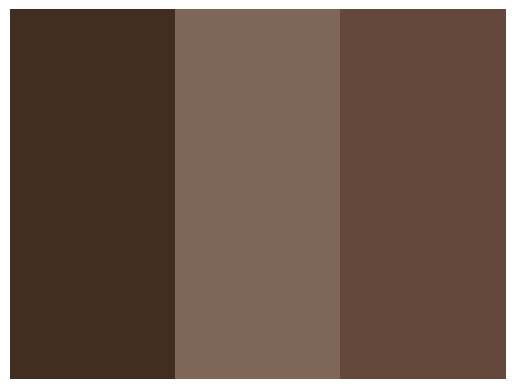


Filename: result_6_0.jpg, Face ID: 0, Label: re


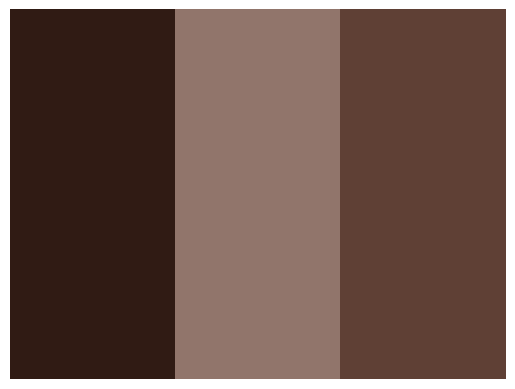


Filename: result_6_0.jpg, Face ID: 0, Label: le


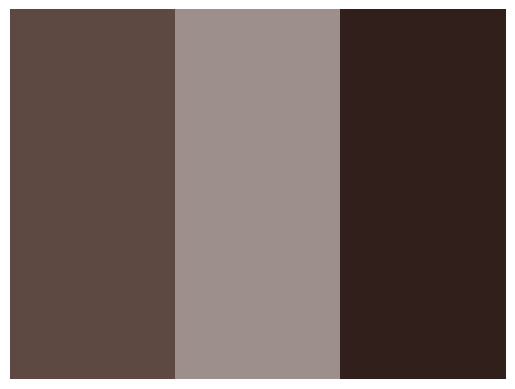


Filename: result_6_0.jpg, Face ID: 0, Label: nose


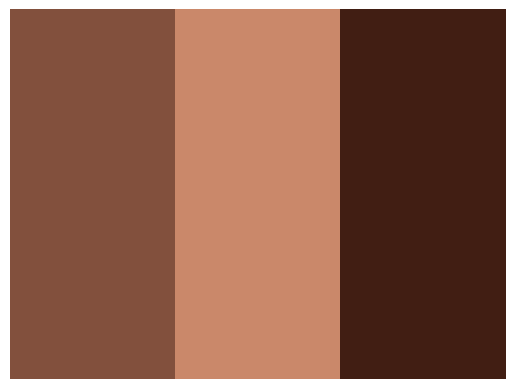


Filename: result_6_0.jpg, Face ID: 0, Label: ulip


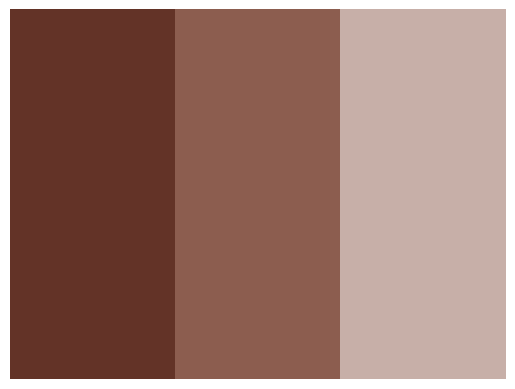


Filename: result_6_0.jpg, Face ID: 0, Label: imouth


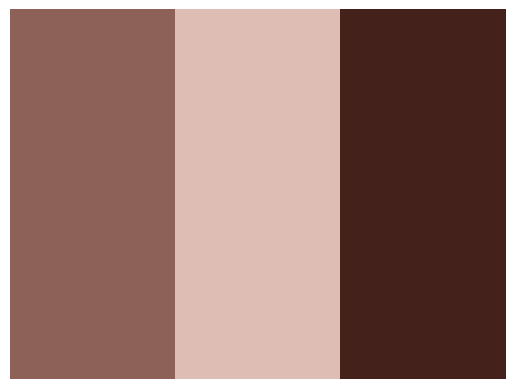


Filename: result_6_0.jpg, Face ID: 0, Label: llip


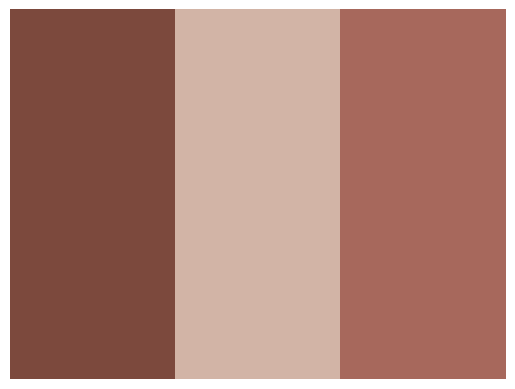


Filename: result_6_0.jpg, Face ID: 0, Label: hair


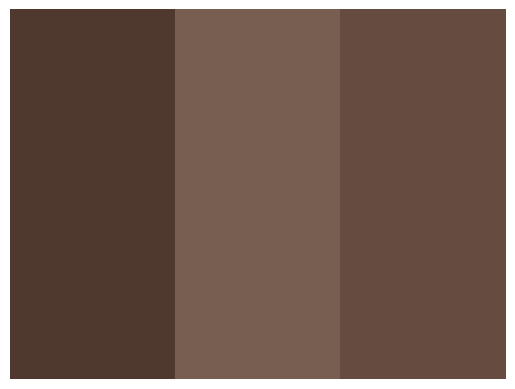

In [14]:
color_extractor.show_colors(dominant_colors)

In [38]:
# Utilizzo della funzione per salvare i dati in un file CSV
color_extractor.save_dominant_colors_to_csv(dominant_colors)

In [34]:
# Inizializza e estrai i colori dominanti dai segmenti facciali
color_clusterer = ColorClusterer(project_dir)

In [ ]:
color_clusterer.label_propagation(dominant_colors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


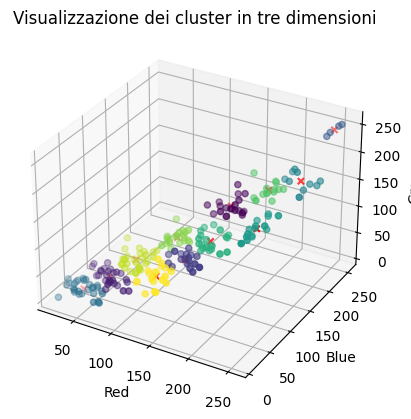

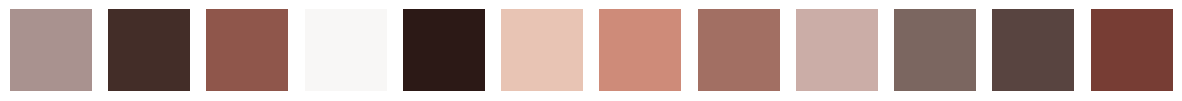

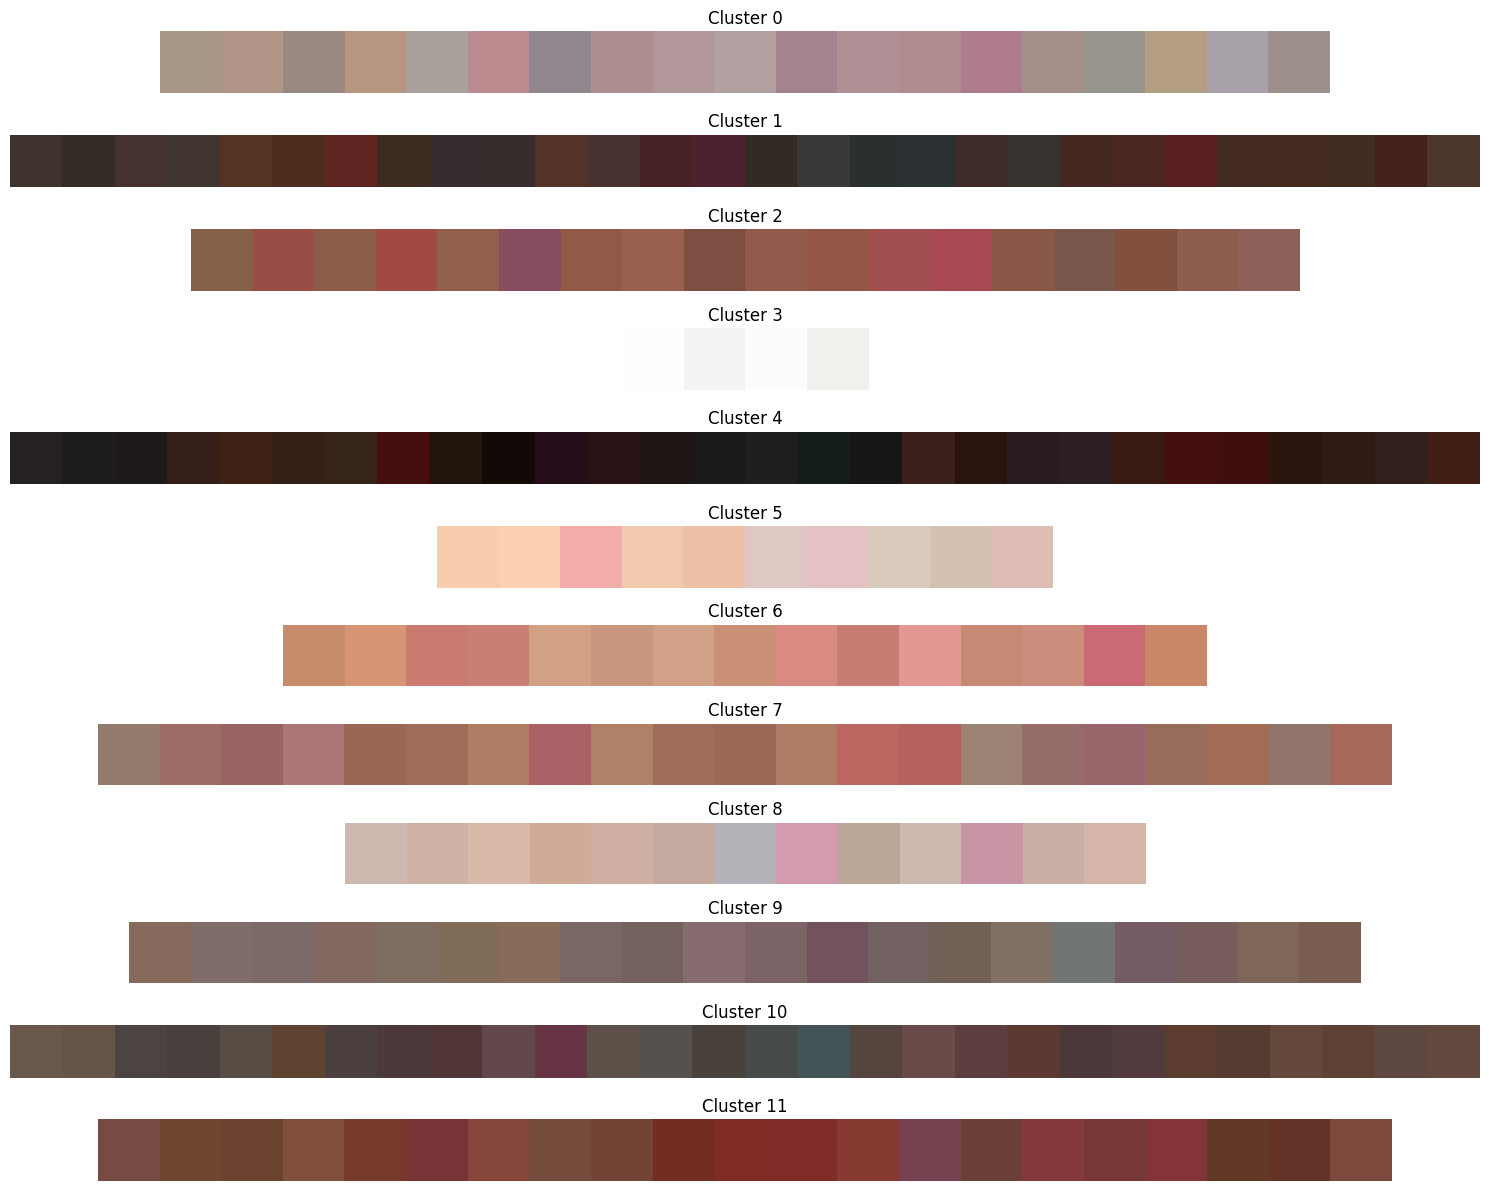

225


In [35]:
color_clusterer.cluster(dominant_colors)

In [ ]:
# Cluster con centroidi predefiniti
seasons_centroids = {
          'Winter': np.array([[0.0, 0.0, 0.5], [0.2, 0.2, 0.6], [0.1, 0.1, 0.3]]),  # Blu freddi e scuri
          'Spring': np.array([[0.9, 0.7, 0.2], [1.0, 0.8, 0.4], [0.8, 0.6, 0.3]]),  # Gialli e verdi chiari e luminosi
          'Summer': np.array([[0.6, 0.6, 0.7], [0.7, 0.7, 0.8], [0.8, 0.8, 0.9]]),  # Blu e grigi chiari e morbidi
          'Autumn': np.array([[0.7, 0.4, 0.1], [0.6, 0.3, 0.1], [0.5, 0.2, 0.0]])   # Marroni e arancioni caldi e terrosi
      }
color_extractor.match_season(dominant_colors, seasons_centroids)
# Stampa i risultati delle associazioni
for filename, faces in season_matches.items():
    for face_id, season in faces.items():
        print(f"Filename: {filename}, Face ID: {face_id}, Season: {season}")

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 9 while Y.shape[1] == 3

### Parte sotto da non considerare

In [ ]:
# Percorso del modello
model_path = os.path.join(project_dir, 'yolov8l-face.pt')

# Assicurati che il percorso del modello sia corretto
assert os.path.exists(model_path), f"Il percorso del modello non è valido"
# Run inference on an image with YOLOv8
model = YOLO(model_path)
results = model(os.path.join(project_dir, 'Faces.jpg'))

AssertionError: Il percorso del modello non è valido

In [ ]:
for i, result in enumerate(results):
    boxes = result.boxes.data  # Boxes object for bounding box outputs

    result.save(filename='result.jpg')
    img = mpimg.imread('result.jpg')
    plt.imshow(img)
    # Itera attraverso tutte le bounding box individuate
    for j, box in enumerate(boxes):
        # Ottieni le coordinate della bounding box
        x_min, y_min, x_max, y_max, conf, cls = box.tolist()[:6]

        # Ritaglia l'area corrispondente dall'immagine originale
        img = Image.open(os.path.join(project_dir, 'Faces.jpg'))
        cropped_img = img.crop((x_min, y_min, x_max, y_max))

        # Salva l'immagine ritagliata
        directory = "faces"
        # Controllo se la cartella esiste, altrimenti la creo
        if not os.path.exists(directory):
            os.makedirs(directory)
        #shutil.rmtree(directory)
        cropped_img.save(os.path.join(directory,f'result_{i}_{"0" * (len(str(len(boxes))) - len(str(j)))}{j}.jpg'))